In [1]:
import xarray as xr
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import regionmask
import shapefile as shp
from math import *
from matplotlib.lines import Line2D
import string
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display, Latex
from uncertainties import unumpy
import warnings
warnings.filterwarnings('ignore')
import gc

In [64]:
##################
# INITIALISATION #
##################

data_path_arome = '/home/monteirod/STAGEIENM3/data_AROME/'
data_path_ADAMONT = '/home/monteirod/STAGEIENM3/data_Adamont/'
data_path_ALADIN = '/home/monteirod/STAGEIENM3/data_Aladin/'

all_ZS = np.arange(0,5100,300)
ls_range = [0,150,450,750,1050,1350,1650,1950,2250,2550,2850,3150,3450,3750,4050,4350,4750,4900]

massif = geopandas.read_file('/home/monteirod/STAGEIENM3/data_S2M/massifs_shapefiles/massifs_alpes_4326.shp')
massif_name=np.array(massif.nom) # Nom des massifs dans l'ordre indice
massif_nums2m = np.array(massif.massif_num) # Numero des massifs dans l'ordre de l'article Arome/Safran
sf = shp.Reader('/home/monteirod/STAGEIENM3/data_S2M/massifs_shapefiles/massifs_alpes_4326.shp')

##########################
# Load mask & topo arome #
##########################

name_oro = 'PGD_setgrid_subset.nc'
oro_ar = xr.open_dataset(data_path_arome+'PGD/'+name_oro)

mask_massif_ar = xr.open_dataset(data_path_arome+'mask_alpes/'+'mask_massif_subset.nc')
mask_massif_ar = mask_massif_ar['__xarray_dataarray_variable__']
mask_massif_ar = mask_massif_ar.rename({'X':'x','Y':'y'})

mask_all_ar = xr.open_dataset(data_path_arome+'mask_alpes/'+'mask_all_subset.nc')
mask_all_ar = mask_all_ar['SFX.AVG_ZS']
mask_all_ar = mask_all_ar.rename({'X':'x','Y':'y'})

oro_ar = oro_ar['SFX.AVG_ZS']
lon_ar = oro_ar.lon[0,:].values
lat_ar = oro_ar.lat[:,0].values
oro_ar = oro_ar.rename({'X':'x','Y':'y'})
oro_ar['y'] = lat_ar
oro_ar['x'] = lon_ar


file_extra = xr.open_dataset('/home/monteirod/STAGEIENM3/data_S2M/alp_flat/file_extra.nc')

#################
# Load DS arome #
#################

all_var = ['Air temperature at 2m','Total precipitation','Fraction of solid precipitation','Snow depth']
all_unit = [' (°C)',' (kg m$^{-2}$)','',' (m)',]

unit = all_unit[0]
var_name = all_var[0]

# run = 'HISTORICAL' #RCP85, HISTORICAL or run_eval/

# Load monmean #

def load_arome_mean_ds(var_name):
    
    if var_name == all_var[0]:
        ar_monmean = xr.open_dataset(data_path_arome+'t2m/'+run+'/monthly_mean/monmean_all_time.nc')
        ar_monmean = ar_monmean.tas-273.15
    if var_name == all_var[1]:
        ar_monmean_grau = xr.open_dataset(data_path_arome+'acc_graupel/'+run+'/monthly_mean/monmean_all_time.nc').graupel*3600
        ar_monmean_pluie = xr.open_dataset(data_path_arome+'acc_pluie/'+run+'/monthly_mean/monmean_all_time.nc').accpluie*3600
        ar_monmean_neige = xr.open_dataset(data_path_arome+'acc_neige/'+run+'/monthly_mean/monmean_all_time.nc').accneige*3600
        ar_monmean = (ar_monmean_grau + ar_monmean_pluie + ar_monmean_neige)
    if var_name == all_var[2]:
        ar_monmean_grau = xr.open_dataset(data_path_arome+'acc_graupel/'+run+'/monthly_mean/monmean_all_time.nc').graupel
        ar_monmean = xr.open_dataset(data_path_arome+'acc_pluie/'+run+'/monthly_mean/monmean_all_time.nc')
        ar_monmean_neige = xr.open_dataset(data_path_arome+'acc_neige/'+run+'/monthly_mean/monmean_all_time.nc').accneige
        ar_monmean['graupel'] = ar_monmean_grau
        ar_monmean['neige'] = ar_monmean_neige
        ar_monmean = ar_monmean.drop_vars(('lon_bnds', 'lat_bnds', 'time_bnds'))*3600
    if var_name == all_var[3]:
        ar_monmean = xr.open_dataset(data_path_arome+'snd/'+run+'/monthly_mean/monmean_all_time.nc')
        ar_monmean = ar_monmean.snd
    ar_monmean['y'] = lat_ar
    ar_monmean['x'] = lon_ar
    return ar_monmean

###########################
# Load mask & topo ALADIN #
###########################


oro_ala_MED = xr.open_dataset(data_path_ALADIN+'orog_MED-11_ECMWF-ERAINT_evaluation_r1i1p1_CNRM-ALADIN63_v1_fx_alps.nc')
mask_massif_ala_MED = xr.open_dataset(data_path_ALADIN+'mask_alpes_MED11/'+'mask_massif_subset.nc')
mask_all_ala_MED = xr.open_dataset(data_path_ALADIN+'mask_alpes_MED11/'+'mask_all_subset.nc')

mask_massif_ala_MED = mask_massif_ala_MED['__xarray_dataarray_variable__']
mask_all_ala_MED = mask_all_ala_MED.orog

oro_ala_MED = oro_ala_MED.orog
lon_MED = oro_ala_MED.lat[:,0].values
lat_MED = oro_ala_MED.lon[0,:].values
oro_ala_MED['x'] = lat_MED
oro_ala_MED['y'] = lon_MED

oro_ala_EUR = xr.open_dataset(data_path_ALADIN+'orog_EUR-11_ECMWF-ERAINT_evaluation_r1i1p1_CNRM-ALADIN63_v1_fx_alps.nc')
mask_massif_ala_EUR = xr.open_dataset(data_path_ALADIN+'mask_alpes_EUR11/'+'mask_massif_subset.nc')
mask_all_ala_EUR = xr.open_dataset(data_path_ALADIN+'mask_alpes_EUR11/'+'mask_all_subset.nc')

mask_massif_ala_EUR = mask_massif_ala_EUR['__xarray_dataarray_variable__']
mask_all_ala_EUR = mask_all_ala_EUR.orog

oro_ala_EUR = oro_ala_EUR.orog
lon_EUR = oro_ala_EUR.lat[:,0].values
lat_EUR = oro_ala_EUR.lon[0,:].values
oro_ala_EUR['x'] = lat_EUR
oro_ala_EUR['y'] = lon_EUR

def load_aladin_mean_ds(var_name):
    
    if var_name == all_var[0]:
        ar_monmean = xr.open_dataset(data_path_ALADIN+run+'/t2m/'+'/monthly_mean/monmean_all_time.nc')
        ar_monmean = ar_monmean.tas-273.15
        if run == 'HISTORICAL' or run == 'RCP85' or run == 'RCP45':
            ar_monmean = ar_monmean.drop_vars('height')
    if var_name == all_var[1]:
        ar_monmean = xr.open_dataset(data_path_ALADIN+run+'/precipitation/'+'/monthly_mean/monmean_all_time.nc')
        ar_monmean = (ar_monmean.pr)*3600*24
    if var_name == all_var[2]:
        ar_monmean = xr.open_dataset(data_path_ALADIN+run+'/precipitation/'+'/monthly_mean/monmean_all_time.nc')
        if run == 'HISTORICAL':
            ar_monmean = ar_monmean.drop_vars(('lon_bnds', 'lat_bnds', 'time_bnds'))*3600*24
        if run == 'run_eval':
            ar_monmean = ar_monmean.drop_vars(('nav_lon_bnds', 'nav_lat_bnds', 'time_counter_bnds'))*3600*24
    if var_name == all_var[3]:
        ar_monmean = xr.open_dataset(data_path_ALADIN+run+'/snd/'+'/monthly_mean/monmean_all_time.nc')
        ar_monmean = ar_monmean.snd
    if run == 'run_eval':
        ar_monmean['x'] = lat_MED
        ar_monmean['y'] = lon_MED
        ar_monmean = ar_monmean.rename({'time_counter': 'time'})
    else:
        ar_monmean['x'] = lat_EUR
        ar_monmean['y'] = lon_EUR
        
    return ar_monmean


#####################
# Load DS ADAMONT   #
#####################

# Hiver 1996/1997 se situe en 1997

def load_Adam_ds(var_name):
        
    if var_name == all_var[0]:
        data = xr.open_dataset(data_path_ADAMONT+run+'/meteo_adamont_'+run+'.nc')
        data = data.Tair-273.15
 
    elif var_name == all_var[1]:
        data = xr.open_dataset(data_path_ADAMONT+run+'/meteo_adamont_'+run+'.nc')
        data = (data.Rainf+data.Snowf)*3600
        
    elif var_name == all_var[2]:
        data = xr.open_dataset(data_path_ADAMONT+run+'/meteo_adamont_'+run+'.nc')
        data = (data*3600)
        
    elif var_name == all_var[3]:
        data = xr.open_dataset(data_path_ADAMONT+run+'/pro_adamont_'+run+'.nc')
        data = data.DSN_T_ISBA
        
    return data

#################
# Load DS S2M   #
#################

def load_ds_s2m(var_name):
    
    if var_name == all_var[0]:
        data = xr.open_dataset('/home/monteirod/STAGEIENM3/data_S2M/alp_flat/Tair_1958_2018.nc')
        data = data.Tair-273.15
 
    elif var_name == all_var[1]:
        data = xr.open_dataset('/home/monteirod/STAGEIENM3/data_S2M/alp_flat/Rainf_Snowf_1958_2018.nc')
        data = (data.Rainf+data.Snowf)*3600
        
    elif var_name == all_var[2]:
        data = xr.open_dataset('/home/monteirod/STAGEIENM3/data_S2M/alp_flat/Rainf_Snowf_1958_2018.nc')
        data = (data*3600)
        
    elif var_name == all_var[3]:
        data = xr.open_dataset('/home/monteirod/STAGEIENM3/data_S2M/alp_flat/snow_1958_2018.nc')
        data = data.DSN_T_ISBA

    return data


#########################
# load ensemble adamont #
#########################

def load_ensemble_adamont(var_name, run):
    r_run = 0
    if run == 'RCP45':
        r_run = 1
        run = 'RCP85'
    ls_var_pr = [ 'precipitation-amount-spring-03-05','precipitation-amount-winter-12-02']
    ls_var_pr_neige = [ 'snowfall-amount-spring-03-05','snowfall-amount-winter-12-02']
    pr = []
    prsn = []
    pr_tot = []
    
    if var_name == all_var[0]:
        data = xr.open_dataset('/home/monteirod/STAGEIENM3/data_eurocordex_4diego/tas-year/'+run+'/all_model.nc')['tas-year']-273.15

    elif var_name == all_var[1]:
        for i in range(0,len(ls_var_pr)):
            pr_tot.append(xr.open_dataset('/home/monteirod/STAGEIENM3/data_eurocordex_4diego/'+ls_var_pr[i]+'/'+run+'/all_model.nc')[ls_var_pr[i]])
        pr_tot = xr.concat(pr_tot, dim = 'season')
        data = pr_tot.sum(dim='season')
    
    elif var_name == all_var[2]:
        for i in range(0,len(ls_var_pr)):
            pr.append(xr.open_dataset('/home/monteirod/STAGEIENM3/data_eurocordex_4diego/'+ls_var_pr[i]+'/'+run+'/all_model.nc')[ls_var_pr[i]])
            prsn.append(xr.open_dataset('/home/monteirod/STAGEIENM3/data_eurocordex_4diego/'+ls_var_pr_neige[i]+'/'+run+'/all_model.nc')[ls_var_pr_neige[i]])
        pr = xr.concat(pr, dim = 'season')
        prsn = xr.concat(prsn, dim = 'season')
        pr = pr.sum(dim='season')
        prsn = prsn.sum(dim = 'season')
        pr_tot = [pr, prsn]
        data = xr.merge(pr_tot).rename({'precipitation-amount-spring-03-05': 'pr', 'snowfall-amount-spring-03-05':'prsn'})
    elif var_name == all_var[3]:
        data = xr.open_dataset('/home/monteirod/STAGEIENM3/data_eurocordex_4diego/sd-winter-11-04-NN/'+run+'/all_model.nc')['sd-winter-11-04-NN']
    if r_run == 1:
        run = 'RCP45'
    return data 

In [62]:
var_name = all_var[2]
load_ensemble_adamont(var_name, run)

<xarray.Dataset>
Dimensions:                            (Number_of_points: 263, sfc: 21, time: 10)
Coordinates:
  * time                               (time) datetime64[ns] 1996-01-01 ... 2005-01-01
  * sfc                                (sfc) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Dimensions without coordinates: Number_of_points
Data variables:
    precipitation-amount-spring-03-05  (time, sfc, Number_of_points) float32 572.07654 ... 906.58215
    snowfall-amount-spring-03-05       (time, sfc, Number_of_points) float32 9.963388 ... 887.6783

In [65]:
# Fonction de moyenne par range d'altitude #

# Note : Le fichier orographie doit avoir les même dim spatial que le ds input

def mean_per_alt(data,ls_range,oro_file,wat = 'arome'): # data : dataset, ls_range : array des altitudes, oro_file : PGD
    ds = []
    ls_range_name = []
    std = []
    nb_points = []
    
    for i in range(0,len(ls_range)-1):
        if wat == 'arome' or wat == 'ALADIN':
            ds.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).mean(dim=('x','y')))
            std.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).std(dim=('x','y')))
        elif wat == 'S2M':
            ds.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).mean(dim=('Number_of_points')))
            std.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).std(dim=('Number_of_points')))

    ds = xr.concat(ds,dim='ZS')
    std = xr.concat(std,dim = 'ZS')
    ds['ZS']  = all_ZS
    std['ZS'] = all_ZS
    return std, ds

####################################################################################

def calc_mean(data,mean_type):

    ds_mean = []
    
    if mean_type == 'month':
        
        num_index = [9,10,11,12,1,2,3,4,5,6,7,8]
        ls_name = ['Sep', 'Oct','Nov', 'Dec','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

        if str(var_name) == all_var[1] or str(var_name)== all_var[2]:
            ds_res = data.resample(time='1MS').sum(skipna = False)
        else: 
            ds_res = data.resample(time='1MS').mean()
    
        for i in range(0,len(num_index)):
            ds_month = ds_res.sel(time=ds_res['time.month'] == num_index[i])
            ds_month = ds_month.groupby('time.year').mean('time')
            ds_mean.append(ds_month)
            
        ds_mean = xr.concat(ds_mean,dim='month')
        ds_mean['month'] = ls_name

    if mean_type == 'season':
        
        num_index = [11,2,5,8]
        ls_name = ['SON','DJF','MAM','JJA']

        if str(var_name) == all_var[1] or str(var_name)== all_var[2]:
            ds_res = data.resample(time='Q-FEB').sum(skipna = False)
        else: 
            ds_res = data.resample(time='Q-FEB').mean()
        
        for i in range(0,len(num_index)):
            ds_season = ds_res.sel(time=ds_res['time.month'] == num_index[i])
            ds_season = ds_season.groupby('time.year').mean('time')
            ds_mean.append(ds_season)
       
        ds_mean = xr.concat(ds_mean,dim='season')
        ds_mean['season'] = ls_name
        
    return ds_mean

def calc_ratio_ar(data):
    ratio = (data.neige+data.graupel)/(data.accpluie+data.neige+data.graupel)
    return ratio

def calc_ratio_s2m(data):
    return (data.Snowf/(data.Rainf+data.Snowf))

def calc_ratio_aladin(data):
    ratio = (data.prsn)/(data.pr)
    return ratio

def per_alt_per_massif(data, style):
    
    data_alt_massif = []
    
    if style == 'S2M':
        
        for i in range(0,23):
            data_alt_massif.append(mean_per_alt(data.where(file_extra.massif_number==massif_nums2m[i]),ls_range,file_extra.ZS,wat = 'S2M')[1])
    
    elif style == 'arome':
        
        for i in range(0,23):
            data_alt_massif.append(mean_per_alt(data.where(mask_massif_ar == i), ls_range, oro_ar)[1])

    elif style == 'ALADIN':
        
        for i in range(0,23):
            data_alt_massif.append(mean_per_alt(data.where(mask_massif_ala == i), ls_range, oro_ala)[1])
        
    data_alt_massif = xr.concat(data_alt_massif, dim = 'massif')
    data_alt_massif['massif'] = massif_name

    return data_alt_massif

In [69]:
###################################
### Ensemble ADAMONT uniquement ###
###################################

alt = 1800
run_all = ['HISTORICAL','RCP45','RCP85']
yr_all = [['1996','2005'],['2041','2050'],['2090','2099']]
PERIOD_var = ['1996-2005','2041-2050','2090-2099']
Period_all = []

mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_EUR, mask_massif_ala_EUR, oro_ala_EUR

for k in range(0,len(run_all)):
    run = run_all[k]
    yr = yr_all[k]
    
    if run == run_all[1]:
        run = 'RCP45'
        mask_ar = per_alt_per_massif(load_arome_mean_ds(all_var[0]).resample(time = '1Y').mean(), style = 'arome')
        run = 'RCP85'
    else:
        mask_ar = per_alt_per_massif(load_arome_mean_ds(all_var[0]).resample(time = '1Y').mean(), style = 'arome')
    ensemble_adam = []
    
    for i in range(0,len(all_var)):

        var_name = all_var[i]

        if var_name == all_var[1]:
            ensemble_adam.append(per_alt_per_massif(load_ensemble_adamont(var_name,run).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))
        elif var_name == all_var[2]:
            ensemble_adam.append(calc_ratio_aladin(per_alt_per_massif(load_ensemble_adamont(var_name,run).resample(time = '1Y').mean(), style = 'S2M')).where(~np.isnan(mask_ar)))

        elif var_name == all_var[3]:
            ensemble_adam.append(per_alt_per_massif(load_ensemble_adamont(var_name,run).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))
        else :
            ensemble_adam.append(per_alt_per_massif(load_ensemble_adamont(var_name,run).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))

    ensemble_adam = xr.concat(ensemble_adam, dim= 'Variable')
    ensemble_adam['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

    dataset_all = []
    
    dataset_all.append(ensemble_adam.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = ('massif','time')).quantile(q = 0.5,dim = 'sfc'))


    Period_all.append(dataset_all)

Period_all

[[<xarray.DataArray 'tas-year' (Variable: 4)>
  array([4.82427992e+00, 6.84338568e+02, 6.61220559e-01, 5.73164941e-01])
  Coordinates:
    * Variable  (Variable) <U33 'Air temperature at 2m (°C)' ... 'Snow depth (m)'
      quantile  float64 0.5], [<xarray.DataArray 'tas-year' (Variable: 4)>
  array([6.45893289e+00, 7.11253371e+02, 5.48185594e-01, 3.82415942e-01])
  Coordinates:
    * Variable  (Variable) <U33 'Air temperature at 2m (°C)' ... 'Snow depth (m)'
      quantile  float64 0.5], [<xarray.DataArray 'tas-year' (Variable: 4)>
  array([9.85159401e+00, 6.30112904e+02, 3.13523223e-01, 1.00998340e-01])
  Coordinates:
    * Variable  (Variable) <U33 'Air temperature at 2m (°C)' ... 'Snow depth (m)'
      quantile  float64 0.5]]

In [4]:
# 1982-2012  & S2M MEAN #

s2m_all = []
ar_all = []
adam_all = []
aladin_all = []

run = 'run_eval'
alt = 1800

mask_ar = per_alt_per_massif(load_arome_mean_ds(all_var[0]).resample(time = '1Y').sum(), style = 'arome') # Egaliser les niveaux d'alt disponible sauf pour ALADIN brute
mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_MED, mask_massif_ala_MED, oro_ala_MED

for i in range(0,len(all_var)):
    
    var_name = all_var[i]
    
    if var_name == all_var[1]:
        s2m_all.append(per_alt_per_massif(load_ds_s2m(var_name).resample(time = '1Y').sum(), style = 'S2M').where(~np.isnan(mask_ar)))
        ar_all.append(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').sum(), style = 'arome'))
        adam_all.append(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').sum(), style = 'S2M').where(~np.isnan(mask_ar)))
        aladin_all.append(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').sum(), style = 'ALADIN'))

    elif var_name == all_var[2]:
        a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice('1982-12','2012-05')).resample(time = '6MS').mean(), style = 'arome')
        ar_all.append(calc_ratio_ar(a.sel(time = a.time.dt.month.isin(12)).resample(time = '1Y').mean()))
        a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice('1982-12','2012-05')).resample(time = '6MS').mean(), style = 'ALADIN')
        aladin_all.append(calc_ratio_aladin(a.sel(time = a.time.dt.month.isin(12)).resample(time = '1Y').mean()))
        a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice('1982-12','2012-05')).resample(time = '6MS').mean(), style = 'S2M')
        adam_all.append(calc_ratio_s2m(a.sel(time = a.time.dt.month.isin(12)).resample(time = '1Y').mean().where(~np.isnan(mask_ar))))
        a = per_alt_per_massif(load_ds_s2m(var_name).sel(time=slice('1961-12','2018-05')).resample(time = '6MS').mean(), style = 'S2M')
        s2m_all.append(calc_ratio_s2m(a.sel(time = a.time.dt.month.isin(12)).resample(time = '1Y').mean().where(~np.isnan(mask_ar))))

    elif var_name == all_var[3]:
        a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice('1982-12','2012-05')).resample(time = '6MS').mean(), style = 'arome')
        ar_all.append(a.sel(time = a.time.dt.month.isin(12)).resample(time = '1Y').mean())
        a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice('1982-12','2012-05')).resample(time = '6MS').mean(), style = 'ALADIN')
        aladin_all.append(a.sel(time = a.time.dt.month.isin(12)).resample(time = '1Y').mean())
        a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice('1982-12','2012-05')).resample(time = '6MS').mean(), style = 'S2M')
        adam_all.append(a.sel(time = a.time.dt.month.isin(12)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
        a = per_alt_per_massif(load_ds_s2m(var_name).sel(time=slice('1961-12','2018-05')).resample(time = '6MS').mean(), style = 'S2M')
        s2m_all.append(a.sel(time = a.time.dt.month.isin(12)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
    else :
        s2m_all.append(per_alt_per_massif(load_ds_s2m(var_name).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))
        ar_all.append(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').mean(), style = 'arome'))
        adam_all.append(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))
        aladin_all.append(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').mean(), style = 'ALADIN'))

s2m_all = xr.concat(s2m_all, dim = 'Variable')
s2m_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

ar_all = xr.concat(ar_all, dim = 'Variable')
ar_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

adam_all = xr.concat(adam_all, dim = 'Variable')
adam_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

aladin_all = xr.concat(aladin_all, dim = 'Variable')
aladin_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

##################################

s2m_clim = []

s2m_clim.append(s2m_all.sel(ZS = alt).sel(time =slice('1961','1990')).mean(dim = ('massif','time')))
s2m_clim.append(s2m_all.sel(ZS = alt).sel(time =slice('1991','2018')).mean(dim = ('massif','time')))
s2m_clim = xr.concat(s2m_clim, dim = 'Period')
s2m_clim['Period'] = ['1961-1990','1991-2018']
s2m_clim.expand_dims(dim = 'Dataset')
s2m_clim['Dataset'] = 'S2M' 

s2m_clim = s2m_clim.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
s2m_clim = s2m_clim.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

##################################

data_1982_2012 = []

data_1982_2012.append(s2m_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = ('massif','time')))
data_1982_2012.append(ar_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = ('massif','time')))
data_1982_2012.append(adam_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = ('massif','time')))
data_1982_2012.append(aladin_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = ('massif','time')))

data_1982_2012 = xr.concat(data_1982_2012, dim = 'Dataset')
data_1982_2012['Dataset'] = ['S2M','ERAi/ALADIN/AROME','ERAi/ALADIN/ADAMONT','ERAi/ALADIN']
data_1982_2012.expand_dims(dim = 'Period')
data_1982_2012['Period'] = '1982-2012'

data_1982_2012 = data_1982_2012.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
data_1982_2012 = data_1982_2012.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

##################################

data_1996_2005 = []

data_1996_2005.append(s2m_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = ('massif','time')))
data_1996_2005.append(ar_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = ('massif','time')))
data_1996_2005.append(adam_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = ('massif','time')))
data_1996_2005.append(aladin_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = ('massif','time')))

data_1996_2005 = xr.concat(data_1996_2005, dim = 'Dataset')
data_1996_2005['Dataset'] = ['S2M','ERAi/ALADIN/AROME','ERAi/ALADIN/ADAMONT','ERAi/ALADIN']
data_1996_2005.expand_dims(dim = 'Period')
data_1996_2005['Period'] = '1996-2005'

data_1996_2005 = data_1996_2005.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
data_1996_2005 = data_1996_2005.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

# Historical and RCP85 #


run_all = ['HISTORICAL','RCP45','RCP85']
yr_all = [['1996','2005'],['2041','2050'],['2090','2099']]
PERIOD_var = ['1996-2005','2041-2050','2090-2099']
Period_all = []

mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_EUR, mask_massif_ala_EUR, oro_ala_EUR

for k in range(0,len(run_all)):
    run = run_all[k]
    yr = yr_all[k]
    
    mask_ar = per_alt_per_massif(load_arome_mean_ds(all_var[0]).resample(time = '1Y').sum(), style = 'arome')

    ar_all = []
    adam_all = []
    aladin_all = []
    ensemble_adam = []
    
    for i in range(0,len(all_var)):

        var_name = all_var[i]

        if var_name == all_var[1]:
            ar_all.append(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').sum(), style = 'arome'))
            adam_all.append(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').sum(), style = 'S2M').where(~np.isnan(mask_ar)))
            aladin_all.append(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').sum(), style = 'ALADIN'))
            if run == run_all[1] or run == run_all[2]:
                ensemble_adam.append(per_alt_per_massif(load_ensemble_adamont(var_name, run).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))
        elif var_name == all_var[2]:
            a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice(yr[0]+'-12',yr[1]+'-05')).resample(time = '6MS').mean(), style = 'arome')
            ar_all.append(calc_ratio_ar(a.sel(time = a.time.dt.month.isin(12)).resample(time = '1Y').mean()))
            a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice(yr[0]+'-12',yr[1]+'-05')).resample(time = '6MS').mean(), style = 'ALADIN')
            aladin_all.append(calc_ratio_aladin(a.sel(time = a.time.dt.month.isin(12)).resample(time = '1Y').mean()))
            a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice(yr[0]+'-12',yr[1]+'-05')).resample(time = '6MS').mean(), style = 'S2M')
            adam_all.append(calc_ratio_s2m(a.sel(time = a.time.dt.month.isin(12)).resample(time = '1Y').mean().where(~np.isnan(mask_ar))))
            if run == run_all[1] or run == run_all[2]:
                ensemble_adam.append(per_alt_per_massif(load_ensemble_adamont(var_name, run).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))

        elif var_name == all_var[3]:
            a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice(yr[0]+'-12',yr[1]+'-05')).resample(time = '6MS').mean(), style = 'arome')
            ar_all.append(a.sel(time = a.time.dt.month.isin(12)).resample(time = '1Y').mean())
            a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice(yr[0]+'-12',yr[1]+'-05')).resample(time = '6MS').mean(), style = 'ALADIN')
            aladin_all.append(a.sel(time = a.time.dt.month.isin(12)).resample(time = '1Y').mean())
            a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice(yr[0]+'-12',yr[1]+'-05')).resample(time = '6MS').mean(), style = 'S2M')
            adam_all.append(a.sel(time = a.time.dt.month.isin(12)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
            if run == run_all[1] or run == run_all[2]:
                ensemble_adam.append(per_alt_per_massif(load_ensemble_adamont(var_name, run).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))
        else :
            ar_all.append(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').mean(), style = 'arome'))
            adam_all.append(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))
            aladin_all.append(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').mean(), style = 'ALADIN'))
            if run == run_all[1] or run == run_all[2]:
                ensemble_adam.append(per_alt_per_massif(load_ensemble_adamont(var_name, run).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))

    ar_all = xr.concat(ar_all, dim = 'Variable')
    ar_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

    adam_all = xr.concat(adam_all, dim = 'Variable')
    adam_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

    aladin_all = xr.concat(aladin_all, dim = 'Variable')
    aladin_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']
    
    if run == run_all[1] or run == run_all[2]:
        ensemble_adam = xr.concat(ensemble_adam, dim= 'Variable')
        ensemble_adam['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

    dataset_all = []
    
    dataset_all.append(ar_all.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = ('massif','time')))
    dataset_all.append(adam_all.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = ('massif','time')))
    dataset_all.append(aladin_all.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = ('massif','time')))
    if run == run_all[1] or run == run_all[2]:
        dataset_all.append(ensemble_adam.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = ('massif','time')).mean(dim = 'sfc'))

    dataset_all = xr.concat(dataset_all, dim = 'Dataset')
    if run == run_all[1] or run == run_all[2]:
        dataset_all['Dataset'] = ['CNMR-CM5/ALADIN/AROME','CNRM-CM5/ALADIN/ADAMONT', 'CNRM-CM5/ALADIN', 'EUROCORDEX/ADAMONT']
    else:
        dataset_all['Dataset'] = ['CNMR-CM5/ALADIN/AROME','CNRM-CM5/ALADIN/ADAMONT', 'CNRM-CM5/ALADIN']

    Period_all.append(dataset_all)
    
Period_all = xr.concat(Period_all, dim = 'Period')
Period_all['Period'] = PERIOD_var
Period_all = Period_all.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
Period_all = Period_all.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

table = pd.concat([s2m_clim,data_1982_2012,data_1996_2005,Period_all])
table.iloc[:,0] = np.around(table.iloc[:,0], decimals = 1)
table.iloc[:,1] = np.around(table.iloc[:,1], decimals = 2)
table.iloc[:,2] = np.around(table.iloc[:,2], decimals = 2)
table.iloc[:,3] = np.around(table.iloc[:,3], decimals = -1)
table_mean = table[['Air temperature at 2m (°C)',
 'Total precipitation (kg m$^{-2}$)',
 'Fraction of solid precipitation',
 'Snow depth (m)']]

table_mean

Variable                           Air temperature at 2m (°C)  \
Period    Dataset                                               
1961-1990 S2M                                             4.3   
1991-2018 S2M                                             4.8   
1982-2012 ERAi/ALADIN                                    -0.8   
          ERAi/ALADIN/ADAMONT                             4.7   
          ERAi/ALADIN/AROME                               3.6   
          S2M                                             4.6   
1996-2005 ERAi/ALADIN                                    -0.8   
          ERAi/ALADIN/ADAMONT                             4.7   
          ERAi/ALADIN/AROME                               3.6   
          S2M                                             4.6   
          CNMR-CM5/ALADIN/AROME                           0.7   
          CNRM-CM5/ALADIN                                -0.1   
          CNRM-CM5/ALADIN/ADAMONT                         4.9   
2041-2050 CNMR-CM5/ALADIN/AROME                           1.9   
          CNRM-CM5/ALADIN                                 1.2   
          CNRM-CM5/ALADIN/ADAMONT                         6.3   
          EUROCORDEX/ADAMONT                              6.5   
2090-2099 CNMR-CM5/ALADIN/AROME                           5.0   
          CNRM-CM5/ALADIN                                 4.5   
          CNRM-CM5/ALADIN/ADAMONT                         9.7   
          EUROCORDEX/ADAMONT                             10.0   

Variable                           Total precipitation (kg m$^{-2}$)  \
Period    Dataset                                                      
1961-1990 S2M                                                 1390.0   
1991-2018 S2M                                                 1390.0   
1982-2012 ERAi/ALADIN                                         1910.0   
          ERAi/ALADIN/ADAMONT                                 1360.0   
          ERAi/ALADIN/AROME                                   1580.0   
          S2M                                                 1380.0   
1996-2005 ERAi/ALADIN                                         1850.0   
          ERAi/ALADIN/ADAMONT                                 1300.0   
          ERAi/ALADIN/AROME                                   1540.0   
          S2M                                                 1380.0   
          CNMR-CM5/ALADIN/AROME                               2190.0   
          CNRM-CM5/ALADIN                                     2630.0   
          CNRM-CM5/ALADIN/ADAMONT                             1330.0   
2041-2050 CNMR-CM5/ALADIN/AROME                               2300.0   
          CNRM-CM5/ALADIN                                     2740.0   
          CNRM-CM5/ALADIN/ADAMONT                             1400.0   
          EUROCORDEX/ADAMONT                                  1400.0   
2090-2099 CNMR-CM5/ALADIN/AROME                               2130.0   
          CNRM-CM5/ALADIN                                     2560.0   
          CNRM-CM5/ALADIN/ADAMONT                             1280.0   
          EUROCORDEX/ADAMONT                                  1180.0   

Variable                           Fraction of solid precipitation  \
Period    Dataset                                                    
1961-1990 S2M                                                 0.73   
1991-2018 S2M                                                 0.67   
1982-2012 ERAi/ALADIN                                         0.63   
          ERAi/ALADIN/ADAMONT                                 0.67   
          ERAi/ALADIN/AROME                                   0.69   
          S2M                                                 0.68   
1996-2005 ERAi/ALADIN                                         0.64   
          ERAi/ALADIN/ADAMONT                                 0.67   
          ERAi/ALADIN/AROME                                   0.69   
          S2M                                                 0.68   
       

In [11]:
# 1982-2012  & S2M STD #

s2m_all = []
ar_all = []
adam_all = []
aladin_all = []

run = 'run_eval'
alt = 1800

mask_ar = per_alt_per_massif(load_arome_mean_ds(all_var[0]).resample(time = '1Y').sum(), style = 'arome')
mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_MED, mask_massif_ala_MED, oro_ala_MED

for i in range(0,len(all_var)):
    
    var_name = all_var[i]
    
    if var_name == all_var[1]:
        s2m_all.append(per_alt_per_massif(load_ds_s2m(var_name).resample(time = '1Y').sum(), style = 'S2M').where(~np.isnan(mask_ar)))
        ar_all.append(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').sum(), style = 'arome'))
        adam_all.append(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').sum(), style = 'S2M').where(~np.isnan(mask_ar)))
        aladin_all.append(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').sum(), style = 'ALADIN'))

    elif var_name == all_var[2]:
        s2m_all.append(calc_ratio_s2m(per_alt_per_massif(load_ds_s2m(var_name).resample(time = '1Y').sum(), style = 'S2M')).where(~np.isnan(mask_ar)))
        ar_all.append(calc_ratio_ar(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').sum(), style = 'arome')))
        adam_all.append(calc_ratio_s2m(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').sum(), style = 'S2M')).where(~np.isnan(mask_ar)))
        aladin_all.append(calc_ratio_aladin(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').sum(), style = 'ALADIN')))

    elif var_name == all_var[3]:
        a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'arome')
        ar_all.append(a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean())
        a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'ALADIN')
        aladin_all.append(a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean())
        a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'S2M')
        adam_all.append(a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
        a = per_alt_per_massif(load_ds_s2m(var_name).sel(time=slice('1961-11','2018-04')).resample(time = '6MS').mean(), style = 'S2M')
        s2m_all.append(a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
    else :
        s2m_all.append(per_alt_per_massif(load_ds_s2m(var_name).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))
        ar_all.append(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').mean(), style = 'arome'))
        adam_all.append(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))
        aladin_all.append(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').mean(), style = 'ALADIN'))

s2m_all = xr.concat(s2m_all, dim = 'Variable')
s2m_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

ar_all = xr.concat(ar_all, dim = 'Variable')
ar_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

adam_all = xr.concat(adam_all, dim = 'Variable')
adam_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

aladin_all = xr.concat(aladin_all, dim = 'Variable')
aladin_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

##################################

s2m_clim = []

s2m_clim.append(s2m_all.sel(ZS = alt).sel(time =slice('1961','1990')).mean(dim = 'massif').std(dim = 'time'))
s2m_clim.append(s2m_all.sel(ZS = alt).sel(time =slice('1991','2018')).mean(dim = 'massif').std(dim = 'time'))
s2m_clim = xr.concat(s2m_clim, dim = 'Period')
s2m_clim['Period'] = ['1961-1990','1991-2018']
s2m_clim.expand_dims(dim = 'Dataset')
s2m_clim['Dataset'] = 'S2M' 

s2m_clim = s2m_clim.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
s2m_clim = s2m_clim.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

##################################

data_1982_2012 = []

data_1982_2012.append(s2m_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = 'massif').std(dim = 'time'))
data_1982_2012.append(ar_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = 'massif').std(dim = 'time'))
data_1982_2012.append(adam_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = 'massif').std(dim = 'time'))
data_1982_2012.append(aladin_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = 'massif').std(dim = 'time'))

data_1982_2012 = xr.concat(data_1982_2012, dim = 'Dataset')
data_1982_2012['Dataset'] = ['S2M','ERAi/ALADIN/AROME','ERAi/ALADIN/ADAMONT', 'ERAi/ALADIN']
data_1982_2012.expand_dims(dim = 'Period')
data_1982_2012['Period'] = '1982-2012'

data_1982_2012 = data_1982_2012.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
data_1982_2012 = data_1982_2012.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

##################################

data_1996_2005 = []

data_1996_2005.append(s2m_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = 'massif').std(dim = 'time'))
data_1996_2005.append(ar_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = 'massif').std(dim = 'time'))
data_1996_2005.append(adam_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = 'massif').std(dim = 'time'))
data_1996_2005.append(aladin_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = 'massif').std(dim = 'time'))

data_1996_2005 = xr.concat(data_1996_2005, dim = 'Dataset')
data_1996_2005['Dataset'] = ['S2M','ERAi/ALADIN/AROME','ERAi/ALADIN/ADAMONT', 'ERAi/ALADIN']
data_1996_2005.expand_dims(dim = 'Period')
data_1996_2005['Period'] = '1996-2005'

data_1996_2005 = data_1996_2005.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
data_1996_2005 = data_1996_2005.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

# Historical and RCP85 #

s2m_all = []
ar_all = []
adam_all = []

run_all = ['HISTORICAL','RCP45','RCP85']
yr_all = [['1996','2005'],['2041','2050'],['2090','2099']]
PERIOD_var = ['1996-2005','2041-2050','2090-2099']
Period_all = []

mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_EUR, mask_massif_ala_EUR, oro_ala_EUR

for k in range(0,len(run_all)):
    run = run_all[k]
    yr = yr_all[k]
    
    mask_ar = per_alt_per_massif(load_arome_mean_ds(all_var[0]).resample(time = '1Y').sum(), style = 'arome')

    ar_all = []
    adam_all = []
    aladin_all = []
    ensemble_adam = []
    
    for i in range(0,len(all_var)):

        var_name = all_var[i]

        if var_name == all_var[1]:
            ar_all.append(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').sum(), style = 'arome'))
            adam_all.append(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').sum(), style = 'S2M').where(~np.isnan(mask_ar)))
            aladin_all.append(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').sum(), style = 'ALADIN'))
            if run == run_all[1] or run == run_all[2]:
                ensemble_adam.append(per_alt_per_massif(load_ensemble_adamont(var_name,run).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))

        elif var_name == all_var[2]:
            a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice(yr[0]+'-12',yr[1]+'-05')).resample(time = '6MS').mean(), style = 'arome')
            ar_all.append(calc_ratio_ar(a.sel(time = a.time.dt.month.isin(12)).resample(time = '1Y').mean()))
            a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice(yr[0]+'-12',yr[1]+'-05')).resample(time = '6MS').mean(), style = 'ALADIN')
            aladin_all.append(calc_ratio_aladin(a.sel(time = a.time.dt.month.isin(12)).resample(time = '1Y').mean()))
            a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice(yr[0]+'-12',yr[1]+'-05')).resample(time = '6MS').mean(), style = 'S2M')
            adam_all.append(calc_ratio_s2m(a.sel(time = a.time.dt.month.isin(12)).resample(time = '1Y').mean().where(~np.isnan(mask_ar))))
            if run == run_all[1] or run == run_all[2]:
                ensemble_adam.append(per_alt_per_massif(load_ensemble_adamont(var_name, run).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))

        elif var_name == all_var[3]:
            a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice(yr[0]+'-12',yr[1]+'-05')).resample(time = '6MS').mean(), style = 'arome')
            ar_all.append(a.sel(time = a.time.dt.month.isin(12)).resample(time = '1Y').mean())
            a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice(yr[0]+'-12',yr[1]+'-05')).resample(time = '6MS').mean(), style = 'ALADIN')
            aladin_all.append(a.sel(time = a.time.dt.month.isin(12)).resample(time = '1Y').mean())
            a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice(yr[0]+'-12',yr[1]+'-05')).resample(time = '6MS').mean(), style = 'S2M')
            adam_all.append(a.sel(time = a.time.dt.month.isin(12)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
            if run == run_all[1] or run == run_all[2]:
                ensemble_adam.append(per_alt_per_massif(load_ensemble_adamont(var_name, run).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))
        else :
            ar_all.append(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').mean(), style = 'arome'))
            adam_all.append(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))
            aladin_all.append(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').mean(), style = 'ALADIN'))
            if run == run_all[1] or run == run_all[2]:
                ensemble_adam.append(per_alt_per_massif(load_ensemble_adamont(var_name,run).resample(time = '1Y').mean(), style = 'S2M').where(~np.isnan(mask_ar)))

    ar_all = xr.concat(ar_all, dim = 'Variable')
    ar_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

    adam_all = xr.concat(adam_all, dim = 'Variable')
    adam_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

    aladin_all = xr.concat(aladin_all, dim = 'Variable')
    aladin_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

    if run == run_all[1] or run == run_all[2]:
        ensemble_adam = xr.concat(ensemble_adam, dim= 'Variable')
        ensemble_adam['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']
    
    dataset_all = []
    
    dataset_all.append(ar_all.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = 'massif').std(dim = 'time'))
    dataset_all.append(adam_all.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = 'massif').std(dim = 'time'))
    dataset_all.append(aladin_all.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = 'massif').std(dim = 'time'))
    if run == run_all[1] or run == run_all[2]:
        dataset_all.append(ensemble_adam.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = ('massif','time')).std(dim = 'sfc'))

    dataset_all = xr.concat(dataset_all, dim = 'Dataset')
    if run == run_all[1] or run == run_all[2]:
        dataset_all['Dataset'] = ['CNMR-CM5/ALADIN/AROME','CNRM-CM5/ALADIN/ADAMONT', 'CNRM-CM5/ALADIN', 'EUROCORDEX/ADAMONT']
    else:
        dataset_all['Dataset'] = ['CNMR-CM5/ALADIN/AROME','CNRM-CM5/ALADIN/ADAMONT', 'CNRM-CM5/ALADIN']

    Period_all.append(dataset_all)
   
Period_all = xr.concat(Period_all, dim = 'Period')
Period_all['Period'] = PERIOD_var
Period_all = Period_all.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
Period_all = Period_all.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

table = pd.concat([s2m_clim,data_1982_2012,data_1996_2005,Period_all])
table.iloc[:,0] = np.around(table.iloc[:,0], decimals = 1)
table.iloc[:,1] = np.around(table.iloc[:,1], decimals = 2)
table.iloc[:,2] = np.around(table.iloc[:,2], decimals = 2)
table.iloc[:,3] = np.around(table.iloc[:,3], decimals = -1)
table_std = table[['Air temperature at 2m (°C)',
 'Total precipitation (kg m$^{-2}$)',
 'Fraction of solid precipitation',
 'Snow depth (m)']]
table_std

table_mean = table_mean.reindex(index = ['S2M','ERAi/ALADIN', 'ERAi/ALADIN/ADAMONT', 'ERAi/ALADIN/AROME','CNRM-CM5/ALADIN','CNRM-CM5/ALADIN/ADAMONT','EUROCORDEX/ADAMONT', 'CNMR-CM5/ALADIN/AROME' ], level = 1)
for i in range(0,4):
    table_mean.iloc[:,i] = unumpy.uarray(table_mean.iloc[:,i],table_std.iloc[:,i])
# display(Latex(table_mean.to_latex()))
table_mean

Variable                          Air temperature at 2m (°C)  \
Period    Dataset                                              
1961-1990 S2M                                      4.3+/-0.6   
1991-2018 S2M                                      4.8+/-0.7   
1982-2012 S2M                                      4.6+/-0.5   
          ERAi/ALADIN                             -0.8+/-0.6   
          ERAi/ALADIN/ADAMONT                      4.7+/-0.5   
          ERAi/ALADIN/AROME                        3.6+/-0.7   
1996-2005 S2M                                      4.6+/-0.5   
          ERAi/ALADIN                             -0.8+/-0.5   
          ERAi/ALADIN/ADAMONT                      4.7+/-0.5   
          ERAi/ALADIN/AROME                        3.6+/-0.6   
          CNRM-CM5/ALADIN                         -0.1+/-0.7   
          CNRM-CM5/ALADIN/ADAMONT                  4.9+/-0.7   
          CNMR-CM5/ALADIN/AROME                    0.7+/-0.8   
2041-2050 CNRM-CM5/ALADIN                          1.2+/-0.6   
          CNRM-CM5/ALADIN/ADAMONT                  6.3+/-0.6   
          EUROCORDEX/ADAMONT                       6.5+/-0.7   
          CNMR-CM5/ALADIN/AROME                    1.9+/-0.5   
2090-2099 CNRM-CM5/ALADIN                          4.5+/-0.6   
          CNRM-CM5/ALADIN/ADAMONT                  9.7+/-0.7   
          EUROCORDEX/ADAMONT                      10.0+/-0.7   
          CNMR-CM5/ALADIN/AROME                    5.0+/-0.8   

Variable                          Total precipitation (kg m$^{-2}$)  \
Period    Dataset                                                     
1961-1990 S2M                                     (1.39+/-0.20)e+03   
1991-2018 S2M                                     (1.39+/-0.17)e+03   
1982-2012 S2M                                     (1.38+/-0.26)e+03   
          ERAi/ALADIN                             (1.91+/-0.20)e+03   
          ERAi/ALADIN/ADAMONT                     (1.36+/-0.21)e+03   
          ERAi/ALADIN/AROME                       (1.58+/-0.18)e+03   
1996-2005 S2M                                     (1.38+/-0.32)e+03   
          ERAi/ALADIN                             (1.85+/-0.25)e+03   
          ERAi/ALADIN/ADAMONT                     (1.30+/-0.24)e+03   
          ERAi/ALADIN/AROME                       (1.54+/-0.21)e+03   
          CNRM-CM5/ALADIN                         (2.63+/-0.30)e+03   
          CNRM-CM5/ALADIN/ADAMONT                 (1.33+/-0.29)e+03   
          CNMR-CM5/ALADIN/AROME                   (2.19+/-0.26)e+03   
2041-2050 CNRM-CM5/ALADIN                         (2.74+/-0.24)e+03   
          CNRM-CM5/ALADIN/ADAMONT                 (1.40+/-0.26)e+03   
          EUROCORDEX/ADAMONT                      (1.40+/-0.18)e+03   
          CNMR-CM5/ALADIN/AROME                   (2.30+/-0.12)e+03   
2090-2099 CNRM-CM5/ALADIN                         (2.56+/-0.18)e+03   
          CNRM-CM5/ALADIN/ADAMONT                 (1.28+/-0.19)e+03   
          EUROCORDEX/ADAMONT                      (1.18+/-0.14)e+03   
          CNMR-CM5/ALADIN/AROME                   (2.13+/-0.14)e+03   

Variable                          Fraction of solid precipitation  \
Period    Dataset                                                   
1961-1990 S2M                                         0.73+/-0.07   
1991-2018 S2M                                         0.67+/-0.06   
1982-2012 S2M                                         0.68+/-0.05   
          ERAi/ALADIN                                 0.63+/-0.07   
          ERAi/ALADIN/ADAMONT                         0.67+/-0.06   
          ERAi/ALADIN/AROME                           0.69+/-0.06   
1996-2005 S2M                                         0.68+/-0.05   
          ERAi/ALADIN                                 0.64+/-0.08   
          ERAi/ALADIN/ADAMONT                         0.67+/-0.06   
          ERAi/ALADIN/AROME                           0.69+/-0.04   
          CNRM-CM5/ALADIN                           0.730+/-0.030

In [ ]:
###################################################
# LE MEME TABLEAU EN SAISON HIVERNALE OU ESTIVALE #
###################################################

In [18]:

# 1982-2012  & S2M MEAN #

s2m_all = []
ar_all = []
adam_all = []
aladin_all = []

season = 11

run = 'run_eval'
alt = 1800

mask_ar = per_alt_per_massif(load_arome_mean_ds(all_var[0]).resample(time = '1Y').sum(), style = 'arome') # Egaliser les niveaux d'alt disponible sauf pour ALADIN brute
mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_MED, mask_massif_ala_MED, oro_ala_MED

for i in range(0,len(all_var)):
    
    var_name = all_var[i]
    
    if var_name == all_var[1]:
        a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').sum(), style = 'arome')
        ar_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
        a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').sum(), style = 'ALADIN')
        aladin_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
        a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').sum(), style = 'S2M')
        adam_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
        a = per_alt_per_massif(load_ds_s2m(var_name).sel(time=slice('1961-11','2018-04')).resample(time = '6MS').sum(), style = 'S2M')
        s2m_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
 
    elif var_name == all_var[2]:
        a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').sum(), style = 'arome')
        ar_all.append(calc_ratio_ar(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean()))
        a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').sum(), style = 'ALADIN')
        aladin_all.append(calc_ratio_aladin(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean()))
        a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').sum(), style = 'S2M')
        adam_all.append(calc_ratio_s2m(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean()).where(~np.isnan(mask_ar)))
        a = per_alt_per_massif(load_ds_s2m(var_name).sel(time=slice('1961-11','2018-04')).resample(time = '6MS').sum(), style = 'S2M')
        s2m_all.append(calc_ratio_s2m(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean()).where(~np.isnan(mask_ar)))
 
    elif var_name == all_var[3]:
        a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'arome')
        ar_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
        a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'ALADIN')
        aladin_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
        a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'S2M')
        adam_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
        a = per_alt_per_massif(load_ds_s2m(var_name).sel(time=slice('1961-11','2018-04')).resample(time = '6MS').mean(), style = 'S2M')
        s2m_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
    else :
        a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'arome')
        ar_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
        a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'ALADIN')
        aladin_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
        a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'S2M')
        adam_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
        a = per_alt_per_massif(load_ds_s2m(var_name).sel(time=slice('1961-11','2018-04')).resample(time = '6MS').mean(), style = 'S2M')
        s2m_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
 

s2m_all = xr.concat(s2m_all, dim = 'Variable')
s2m_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

ar_all = xr.concat(ar_all, dim = 'Variable')
ar_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

adam_all = xr.concat(adam_all, dim = 'Variable')
adam_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

aladin_all = xr.concat(aladin_all, dim = 'Variable')
aladin_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

##################################

s2m_clim = []

s2m_clim.append(s2m_all.sel(ZS = alt).sel(time =slice('1961','1990')).mean(dim = ('massif','time')))
s2m_clim.append(s2m_all.sel(ZS = alt).sel(time =slice('1991','2018')).mean(dim = ('massif','time')))
s2m_clim = xr.concat(s2m_clim, dim = 'Period')
s2m_clim['Period'] = ['1961-1990','1991-2018']
s2m_clim.expand_dims(dim = 'Dataset')
s2m_clim['Dataset'] = 'S2M' 

s2m_clim = s2m_clim.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
s2m_clim = s2m_clim.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

##################################

data_1982_2012 = []

data_1982_2012.append(s2m_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = ('massif','time')))
data_1982_2012.append(ar_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = ('massif','time')))
data_1982_2012.append(adam_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = ('massif','time')))
data_1982_2012.append(aladin_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = ('massif','time')))

data_1982_2012 = xr.concat(data_1982_2012, dim = 'Dataset')
data_1982_2012['Dataset'] = ['S2M','ERAi/ALADIN/AROME','ERAi/ALADIN/ADAMONT','ERAi/ALADIN']
data_1982_2012.expand_dims(dim = 'Period')
data_1982_2012['Period'] = '1982-2012'

data_1982_2012 = data_1982_2012.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
data_1982_2012 = data_1982_2012.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

##################################

data_1996_2005 = []

data_1996_2005.append(s2m_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = ('massif','time')))
data_1996_2005.append(ar_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = ('massif','time')))
data_1996_2005.append(adam_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = ('massif','time')))
data_1996_2005.append(aladin_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = ('massif','time')))

data_1996_2005 = xr.concat(data_1996_2005, dim = 'Dataset')
data_1996_2005['Dataset'] = ['S2M','ERAi/ALADIN/AROME','ERAi/ALADIN/ADAMONT','ERAi/ALADIN']
data_1996_2005.expand_dims(dim = 'Period')
data_1996_2005['Period'] = '1996-2005'

data_1996_2005 = data_1996_2005.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
data_1996_2005 = data_1996_2005.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

# Historical and RCP85 #


run_all = ['HISTORICAL','RCP45','RCP85']
yr_all = [['1996','2005'],['2041','2050'],['2090','2099']]
PERIOD_var = ['1996-2005','2041-2050','2090-2099']
Period_all = []

mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_EUR, mask_massif_ala_EUR, oro_ala_EUR

for k in range(0,len(run_all)):
    run = run_all[k]
    yr = yr_all[k]
    
    mask_ar = per_alt_per_massif(load_arome_mean_ds(all_var[0]).resample(time = '1Y').sum(), style = 'arome')

    ar_all = []
    adam_all = []
    aladin_all = []
    
    for i in range(0,len(all_var)):

        var_name = all_var[i]

        if var_name == all_var[1]:
            a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').sum(), style = 'arome')
            ar_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
            a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').sum(), style = 'ALADIN')
            aladin_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
            a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').sum(), style = 'S2M')
            adam_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))

        elif var_name == all_var[2]:
            a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').sum(), style = 'arome')
            ar_all.append(calc_ratio_ar(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean()))
            a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').sum(), style = 'ALADIN')
            aladin_all.append(calc_ratio_aladin(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean()))
            a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').sum(), style = 'S2M')
            adam_all.append(calc_ratio_s2m(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean()).where(~np.isnan(mask_ar)))

        elif var_name == all_var[3]:
            a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').mean(), style = 'arome')
            ar_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
            a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').mean(), style = 'ALADIN')
            aladin_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
            a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').mean(), style = 'S2M')
            adam_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
        else :
            a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').mean(), style = 'arome')
            ar_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
            a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').mean(), style = 'ALADIN')
            aladin_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
            a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').mean(), style = 'S2M')
            adam_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
 
    ar_all = xr.concat(ar_all, dim = 'Variable')
    ar_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

    adam_all = xr.concat(adam_all, dim = 'Variable')
    adam_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

    aladin_all = xr.concat(aladin_all, dim = 'Variable')
    aladin_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']
    
    dataset_all = []
    
    dataset_all.append(ar_all.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = ('massif','time')))
    dataset_all.append(adam_all.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = ('massif','time')))
    dataset_all.append(aladin_all.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = ('massif','time')))

    dataset_all = xr.concat(dataset_all, dim = 'Dataset')
    dataset_all['Dataset'] = ['CNMR-CM5/ALADIN/AROME','CNRM-CM5/ALADIN/ADAMONT', 'CNRM-CM5/ALADIN']

    Period_all.append(dataset_all)
    
Period_all = xr.concat(Period_all, dim = 'Period')
Period_all['Period'] = PERIOD_var
Period_all = Period_all.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
Period_all = Period_all.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

table = pd.concat([s2m_clim,data_1982_2012,data_1996_2005,Period_all])
table.iloc[:,0] = np.around(table.iloc[:,0], decimals = 1)
table.iloc[:,1] = np.around(table.iloc[:,1], decimals = 2)
table.iloc[:,2] = np.around(table.iloc[:,2], decimals = 2)
table.iloc[:,3] = np.around(table.iloc[:,3], decimals = -1)
table_mean = table[['Air temperature at 2m (°C)',
 'Total precipitation (kg m$^{-2}$)',
 'Fraction of solid precipitation',
 'Snow depth (m)']]
table_mean

Variable                           Air temperature at 2m (°C)  \
Period    Dataset                                               
1961-1990 S2M                                            -0.7   
1991-2018 S2M                                            -0.4   
1982-2012 ERAi/ALADIN                                    -6.6   
          ERAi/ALADIN/ADAMONT                            -0.6   
          ERAi/ALADIN/AROME                              -1.9   
          S2M                                            -0.6   
1996-2005 ERAi/ALADIN                                    -6.7   
          ERAi/ALADIN/ADAMONT                            -0.8   
          ERAi/ALADIN/AROME                              -2.0   
          S2M                                            -0.7   
          CNMR-CM5/ALADIN/AROME                          -3.8   
          CNRM-CM5/ALADIN                                -6.0   
          CNRM-CM5/ALADIN/ADAMONT                        -0.2   
2041-2050 CNMR-CM5/ALADIN/AROME                          -2.8   
          CNRM-CM5/ALADIN                                -4.7   
          CNRM-CM5/ALADIN/ADAMONT                         0.9   
2090-2099 CNMR-CM5/ALADIN/AROME                          -0.3   
          CNRM-CM5/ALADIN                                -1.7   
          CNRM-CM5/ALADIN/ADAMONT                         3.7   

Variable                           Total precipitation (kg m$^{-2}$)  \
Period    Dataset                                                      
1961-1990 S2M                                                  710.0   
1991-2018 S2M                                                  710.0   
1982-2012 ERAi/ALADIN                                         1000.0   
          ERAi/ALADIN/ADAMONT                                  720.0   
          ERAi/ALADIN/AROME                                    850.0   
          S2M                                                  710.0   
1996-2005 ERAi/ALADIN                                          990.0   
          ERAi/ALADIN/ADAMONT                                  700.0   
          ERAi/ALADIN/AROME                                    840.0   
          S2M                                                  700.0   
          CNMR-CM5/ALADIN/AROME                               1110.0   
          CNRM-CM5/ALADIN                                     1270.0   
          CNRM-CM5/ALADIN/ADAMONT                              690.0   
2041-2050 CNMR-CM5/ALADIN/AROME                               1200.0   
          CNRM-CM5/ALADIN                                     1320.0   
          CNRM-CM5/ALADIN/ADAMONT                              710.0   
2090-2099 CNMR-CM5/ALADIN/AROME                               1250.0   
          CNRM-CM5/ALADIN                                     1440.0   
          CNRM-CM5/ALADIN/ADAMONT                              720.0   

Variable                           Fraction of solid precipitation  \
Period    Dataset                                                    
1961-1990 S2M                                                 0.77   
1991-2018 S2M                                                 0.72   
1982-2012 ERAi/ALADIN                                         0.73   
          ERAi/ALADIN/ADAMONT                                 0.71   
          ERAi/ALADIN/AROME                                   0.75   
          S2M                                                 0.73   
1996-2005 ERAi/ALADIN                                         0.71   
          ERAi/ALADIN/ADAMONT                                 0.72   
          ERAi/ALADIN/AROME                                   0.76   
          S2M                                                 0.73   
          CNMR-CM5/ALADIN/AROME                               0.89   
          CNRM-CM5/ALADIN                                     0.76   
          CNRM-CM5/ALADIN/ADAMONT                             0.71   
2041-2050 CNMR-CM5/ALADIN/AROME                               0.77   
 

In [19]:
# 1982-2012  & S2M STD #

s2m_all = []
ar_all = []
adam_all = []
aladin_all = []
season = 11
run = 'run_eval'
alt = 1800

mask_ar = per_alt_per_massif(load_arome_mean_ds(all_var[0]).resample(time = '1Y').sum(), style = 'arome')
mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_MED, mask_massif_ala_MED, oro_ala_MED

for i in range(0,len(all_var)):
    
    var_name = all_var[i]
    
    if var_name == all_var[1]:
        a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').sum(), style = 'arome')
        ar_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
        a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').sum(), style = 'ALADIN')
        aladin_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
        a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').sum(), style = 'S2M')
        adam_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
        a = per_alt_per_massif(load_ds_s2m(var_name).sel(time=slice('1961-11','2018-04')).resample(time = '6MS').sum(), style = 'S2M')
        s2m_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
 
    elif var_name == all_var[2]:
        a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').sum(), style = 'arome')
        ar_all.append(calc_ratio_ar(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean()))
        a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').sum(), style = 'ALADIN')
        aladin_all.append(calc_ratio_aladin(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean()))
        a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').sum(), style = 'S2M')
        adam_all.append(calc_ratio_s2m(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean()).where(~np.isnan(mask_ar)))
        a = per_alt_per_massif(load_ds_s2m(var_name).sel(time=slice('1961-11','2018-04')).resample(time = '6MS').sum(), style = 'S2M')
        s2m_all.append(calc_ratio_s2m(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean()).where(~np.isnan(mask_ar)))
 
    elif var_name == all_var[3]:
        a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'arome')
        ar_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
        a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'ALADIN')
        aladin_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
        a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'S2M')
        adam_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
        a = per_alt_per_massif(load_ds_s2m(var_name).sel(time=slice('1961-11','2018-04')).resample(time = '6MS').mean(), style = 'S2M')
        s2m_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
    else :
        a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'arome')
        ar_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
        a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'ALADIN')
        aladin_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
        a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice('1982-11','2012-04')).resample(time = '6MS').mean(), style = 'S2M')
        adam_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
        a = per_alt_per_massif(load_ds_s2m(var_name).sel(time=slice('1961-11','2018-04')).resample(time = '6MS').mean(), style = 'S2M')
        s2m_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
 
s2m_all = xr.concat(s2m_all, dim = 'Variable')
s2m_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

ar_all = xr.concat(ar_all, dim = 'Variable')
ar_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

adam_all = xr.concat(adam_all, dim = 'Variable')
adam_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

aladin_all = xr.concat(aladin_all, dim = 'Variable')
aladin_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

##################################

s2m_clim = []

s2m_clim.append(s2m_all.sel(ZS = alt).sel(time =slice('1961','1990')).mean(dim = 'massif').std(dim = 'time'))
s2m_clim.append(s2m_all.sel(ZS = alt).sel(time =slice('1991','2018')).mean(dim = 'massif').std(dim = 'time'))
s2m_clim = xr.concat(s2m_clim, dim = 'Period')
s2m_clim['Period'] = ['1961-1990','1991-2018']
s2m_clim.expand_dims(dim = 'Dataset')
s2m_clim['Dataset'] = 'S2M' 

s2m_clim = s2m_clim.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
s2m_clim = s2m_clim.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

##################################

data_1982_2012 = []

data_1982_2012.append(s2m_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = 'massif').std(dim = 'time'))
data_1982_2012.append(ar_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = 'massif').std(dim = 'time'))
data_1982_2012.append(adam_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = 'massif').std(dim = 'time'))
data_1982_2012.append(aladin_all.sel(ZS = alt).sel(time =slice('1982','2012')).mean(dim = 'massif').std(dim = 'time'))

data_1982_2012 = xr.concat(data_1982_2012, dim = 'Dataset')
data_1982_2012['Dataset'] = ['S2M','ERAi/ALADIN/AROME','ERAi/ALADIN/ADAMONT', 'ERAi/ALADIN']
data_1982_2012.expand_dims(dim = 'Period')
data_1982_2012['Period'] = '1982-2012'

data_1982_2012 = data_1982_2012.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
data_1982_2012 = data_1982_2012.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

##################################

data_1996_2005 = []

data_1996_2005.append(s2m_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = 'massif').std(dim = 'time'))
data_1996_2005.append(ar_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = 'massif').std(dim = 'time'))
data_1996_2005.append(adam_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = 'massif').std(dim = 'time'))
data_1996_2005.append(aladin_all.sel(ZS = alt).sel(time =slice('1996','2005')).mean(dim = 'massif').std(dim = 'time'))

data_1996_2005 = xr.concat(data_1996_2005, dim = 'Dataset')
data_1996_2005['Dataset'] = ['S2M','ERAi/ALADIN/AROME','ERAi/ALADIN/ADAMONT', 'ERAi/ALADIN']
data_1996_2005.expand_dims(dim = 'Period')
data_1996_2005['Period'] = '1996-2005'

data_1996_2005 = data_1996_2005.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
data_1996_2005 = data_1996_2005.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

# Historical and RCP85 #

s2m_all = []
ar_all = []
adam_all = []

run_all = ['HISTORICAL','RCP45','RCP85']
yr_all = [['1996','2005'],['2041','2050'],['2090','2099']]
PERIOD_var = ['1996-2005','2041-2050','2090-2099']
Period_all = []

mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_EUR, mask_massif_ala_EUR, oro_ala_EUR

for k in range(0,len(run_all)):
    run = run_all[k]
    yr = yr_all[k]
    
    mask_ar = per_alt_per_massif(load_arome_mean_ds(all_var[0]).resample(time = '1Y').sum(), style = 'arome')

    ar_all = []
    adam_all = []
    aladin_all = []
    
    for i in range(0,len(all_var)):

        var_name = all_var[i]

        if var_name == all_var[1]:
            a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').sum(), style = 'arome')
            ar_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
            a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').sum(), style = 'ALADIN')
            aladin_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
            a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').sum(), style = 'S2M')
            adam_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))

        elif var_name == all_var[2]:
            a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').sum(), style = 'arome')
            ar_all.append(calc_ratio_ar(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean()))
            a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').sum(), style = 'ALADIN')
            aladin_all.append(calc_ratio_aladin(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean()))
            a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').sum(), style = 'S2M')
            adam_all.append(calc_ratio_s2m(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean()).where(~np.isnan(mask_ar)))

        elif var_name == all_var[3]:
            a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').mean(), style = 'arome')
            ar_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
            a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').mean(), style = 'ALADIN')
            aladin_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
            a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').mean(), style = 'S2M')
            adam_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
        else :
            a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').mean(), style = 'arome')
            ar_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
            a = per_alt_per_massif(load_aladin_mean_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').mean(), style = 'ALADIN')
            aladin_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean())
            a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice(yr[0]+'-11',yr[1]+'-04')).resample(time = '6MS').mean(), style = 'S2M')
            adam_all.append(a.sel(time = a.time.dt.month.isin(season)).resample(time = '1Y').mean().where(~np.isnan(mask_ar)))
 
    ar_all = xr.concat(ar_all, dim = 'Variable')
    ar_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

    adam_all = xr.concat(adam_all, dim = 'Variable')
    adam_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']

    aladin_all = xr.concat(aladin_all, dim = 'Variable')
    aladin_all['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)','Fraction of solid precipitation', 'Snow depth (m)']
    
    dataset_all = []
    
    dataset_all.append(ar_all.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = 'massif').std(dim = 'time'))
    dataset_all.append(adam_all.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = 'massif').std(dim = 'time'))
    dataset_all.append(aladin_all.sel(ZS = alt).sel(time =slice(yr[0],yr[1])).mean(dim = 'massif').std(dim = 'time'))

    dataset_all = xr.concat(dataset_all, dim = 'Dataset')
    dataset_all['Dataset'] = ['CNMR-CM5/ALADIN/AROME','CNRM-CM5/ALADIN/ADAMONT', 'CNRM-CM5/ALADIN']

    Period_all.append(dataset_all)
    
Period_all = xr.concat(Period_all, dim = 'Period')
Period_all['Period'] = PERIOD_var
Period_all = Period_all.drop_vars('ZS').to_dataset(name = 'Values').to_dataframe()
Period_all = Period_all.pivot_table(index = ('Period','Dataset'), columns = 'Variable', values = 'Values')

table = pd.concat([s2m_clim,data_1982_2012,data_1996_2005,Period_all])
table.iloc[:,0] = np.around(table.iloc[:,0], decimals = 1)
table.iloc[:,1] = np.around(table.iloc[:,1], decimals = 2)
table.iloc[:,2] = np.around(table.iloc[:,2], decimals = 2)
table.iloc[:,3] = np.around(table.iloc[:,3], decimals = -1)
table_std = table[['Air temperature at 2m (°C)',
 'Total precipitation (kg m$^{-2}$)',
 'Fraction of solid precipitation',
 'Snow depth (m)']]
table_std

table_mean = table_mean.reindex(index = ['S2M','ERAi/ALADIN', 'ERAi/ALADIN/ADAMONT', 'ERAi/ALADIN/AROME','CNRM-CM5/ALADIN','CNRM-CM5/ALADIN/ADAMONT', 'CNMR-CM5/ALADIN/AROME' ], level = 1)
for i in range(0,4):
    table_mean.iloc[:,i] = unumpy.uarray(table_mean.iloc[:,i],table_std.iloc[:,i])
display(Latex(table_mean.to_latex())), table_mean

<IPython.core.display.Latex object>

(None,
 Variable                          Air temperature at 2m (°C)  \
 Period    Dataset                                              
 1961-1990 S2M                                     -0.7+/-1.0   
 1991-2018 S2M                                     -0.4+/-0.9   
 1982-2012 S2M                                     -0.6+/-0.8   
           ERAi/ALADIN                             -6.6+/-0.9   
           ERAi/ALADIN/ADAMONT                     -0.6+/-0.8   
           ERAi/ALADIN/AROME                       -1.9+/-0.9   
 1996-2005 S2M                                     -0.7+/-0.8   
           ERAi/ALADIN                             -6.7+/-0.7   
           ERAi/ALADIN/ADAMONT                     -0.8+/-0.6   
           ERAi/ALADIN/AROME                       -2.0+/-0.7   
           CNRM-CM5/ALADIN                         -6.0+/-0.9   
           CNRM-CM5/ALADIN/ADAMONT                 -0.2+/-1.0   
           CNMR-CM5/ALADIN/AROME                   -3.8+/-0.9   
 2041-2050 CNRM-CM

In [4]:
################################
### Compare all in 1996-2005 ###
################################

run = 'HISTORICAL'
yr = ['1996','2005'] #['2090','2099']

mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_EUR, mask_massif_ala_EUR, oro_ala_EUR
mask_ar = per_alt_per_massif(load_arome_mean_ds(all_var[0]).resample(time = '1Y').sum(), style = 'arome')

ar_cnrm = []
adam_cnrm = []
aladin_cnrm = []

for i in range(0,2):

    var_name = all_var[i]

    if var_name == all_var[1]:
        ar_cnrm.append(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').sum(), style = 'arome').sel(time =slice(yr[0],yr[1])))
        adam_cnrm.append(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').sum(), style = 'S2M').sel(time =slice(yr[0],yr[1])).where(~np.isnan(mask_ar)))
        aladin_cnrm.append(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').sum(), style = 'ALADIN').sel(time =slice(yr[0],yr[1])))
    else :
        ar_cnrm.append(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').mean(), style = 'arome').sel(time =slice(yr[0],yr[1])))
        adam_cnrm.append(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').mean(), style = 'S2M').sel(time =slice(yr[0],yr[1])).where(~np.isnan(mask_ar)))
        aladin_cnrm.append(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').mean(), style = 'ALADIN').sel(time =slice(yr[0],yr[1])))

run = 'run_eval'
ar_erai = []
adam_erai = []
aladin_erai = []
s2m = []

mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_MED, mask_massif_ala_MED, oro_ala_MED

for i in range(0,2):

    var_name = all_var[i]

    if var_name == all_var[1]:
        s2m.append(per_alt_per_massif(load_ds_s2m(var_name).resample(time = '1Y').sum(), style = 'S2M').sel(time =slice(yr[0],yr[1])).where(~np.isnan(mask_ar)))
        ar_erai.append(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').sum(), style = 'arome').sel(time =slice(yr[0],yr[1])))
        adam_erai.append(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').sum(), style = 'S2M').sel(time =slice(yr[0],yr[1])).where(~np.isnan(mask_ar)))
        aladin_erai.append(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').sum(), style = 'ALADIN').sel(time =slice(yr[0],yr[1])))
    else :
        s2m.append(per_alt_per_massif(load_ds_s2m(var_name).resample(time = '1Y').mean(), style = 'S2M').sel(time =slice(yr[0],yr[1])).where(~np.isnan(mask_ar)))
        ar_erai.append(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').mean(), style = 'arome').sel(time =slice(yr[0],yr[1])))
        adam_erai.append(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').mean(), style = 'S2M').sel(time =slice(yr[0],yr[1])).where(~np.isnan(mask_ar)))
        aladin_erai.append(per_alt_per_massif(load_aladin_mean_ds(var_name).resample(time = '1Y').mean(), style = 'ALADIN').sel(time =slice(yr[0],yr[1])))

        
ar_cnrm = xr.concat(ar_cnrm, dim = 'Variable')
ar_cnrm['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)']

ar_erai = xr.concat(ar_erai, dim = 'Variable')
ar_erai['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)']

adam_cnrm = xr.concat(adam_cnrm, dim = 'Variable')
adam_cnrm['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)']

adam_erai = xr.concat(adam_erai, dim = 'Variable')
adam_erai['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)']

aladin_cnrm = xr.concat(aladin_cnrm, dim = 'Variable')
aladin_cnrm['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)']

aladin_erai = xr.concat(aladin_erai, dim = 'Variable')
aladin_erai['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)']

s2m = xr.concat(s2m, dim = 'Variable')
s2m['Variable'] = ['Air temperature at 2m (°C)','Total precipitation (kg m$^{-2}$)']

dataset_all = [ar_cnrm, ar_erai, adam_cnrm, adam_erai, aladin_cnrm, aladin_erai, s2m]
dataset_all = xr.concat(dataset_all, dim = 'Dataset')
dataset_all['Dataset'] = ['CNMR-CM5/ALADIN/AROME','ERAi/ALADIN/AROME','CNRM-CM5/ALADIN/ADAMONT','ERAi/ALADIN/ADAMONT', 'CNRM-CM5/ALADIN', 'ERAi/ALADIN', 'S2M']

dataset_all

<xarray.DataArray 'tas' (Dataset: 7, Variable: 2, massif: 23, ZS: 17, time: 10)>
array([[[[[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [ 7.76883411e+00,  7.30262184e+00,  6.28381681e+00, ...,
            7.89115858e+00,  8.46976852e+00,  6.98488426e+00],
          ...,
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]],

         [[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [ 8.09886265e+00,  7.62754250e+00,  6.61461449e+00, ...,
            8.20186138e+00,  8.86214161e+00,  7.30238581e+00],
          ...,
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]],

         [[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [ 7.39998531e+00,  6.78270626e+00,  5.78795528e+00, ...,
            7.45923710e+00,  8.18313789e+00,  6.49419117e+00],
          ...,
          [-1.41627007e+01, -1.42556190e+01, -1.51576080e+01, ...,
           -1.36730185e+01, -1.30641518e+01, -1.42056389e+01],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]],

         ...,

         [[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          ...,
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]],

         [[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [ 9.72575569e+00,  9.37631035e+00,  8.77120590e+00, ...,
            9.86241722e+00,  9.61639214e+00,  9.13540077e+00],
          ...,
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,       

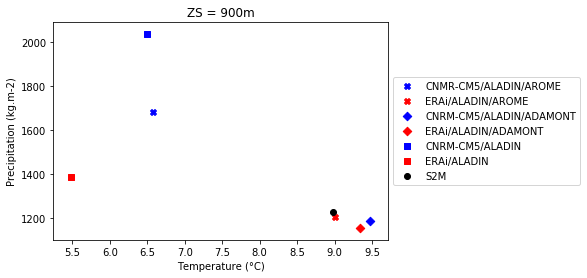

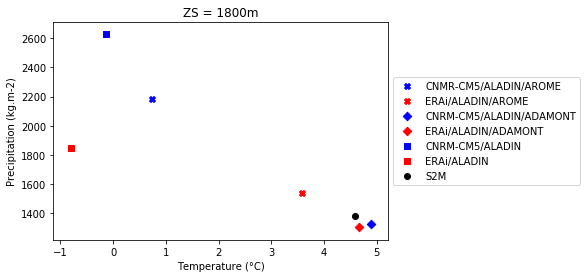

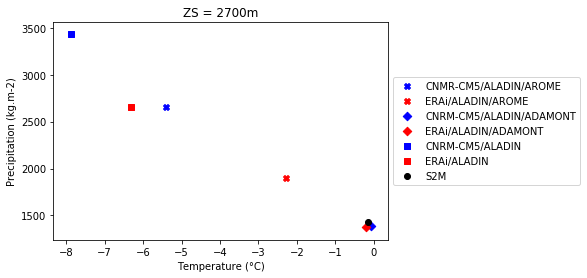

In [24]:
########
# Plot #
########

marker = ['X','X','D','D','s','s','o']
color = ['blue','r','blue','r','blue','r','black']
alt = [900,1800,2700]

for j in range(0,len(alt)):
    plt.figure()
    for i in range(0,len(dataset_all.Dataset)):
        plt.scatter(dataset_all.isel(Dataset = i, Variable = 0).mean(dim = ('massif','time')).sel(ZS = alt[j]),dataset_all.isel(Dataset = i, Variable = 1).mean(dim = ('massif','time')).sel(ZS = alt[j]), label = dataset_all.Dataset[i].values, marker = marker[i], color = color[i])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Precipitation (kg.m-2)')
    plt.title('ZS = '+str(alt[j])+'m')

In [11]:
P_AROME = dataset_all.sel(Dataset = 'CNMR-CM5/ALADIN/AROME').sel(Variable = 'Air temperature at 2m (°C)').mean(dim = 'time')
R_AROME = dataset_all.sel(Dataset = 'ERAi/ALADIN/AROME').sel(Variable = 'Air temperature at 2m (°C)').mean(dim = 'time')

No handles with labels found to put in legend.


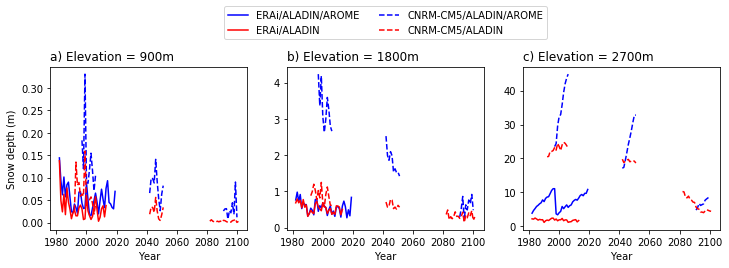

In [5]:
# Plot accumulation neige #

fig, ax = plt.subplots(1,3,figsize=(12,3))

# Plot #

alt_a = [900,1800,2700]
letter = ['a) ','b) ', 'c) ']
for i in range(0,len(alt_a)):
    
    alt = alt_a[i]
    
    run = 'run_eval'
    mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_MED, mask_massif_ala_MED, oro_ala_MED
    ar_snow = per_alt_per_massif(load_arome_mean_ds(all_var[3]).resample(time = '1Y').mean(),'arome').mean(dim ='massif')
    aladin_snow = per_alt_per_massif(load_aladin_mean_ds(all_var[3]).resample(time = '1Y').mean(),'ALADIN').mean(dim ='massif')

    ax[i].plot(ar_snow.time, ar_snow.sel(ZS = alt), linestyle = '-',color = 'blue', label = 'ERAi/ALADIN/AROME')
    ax[i].plot(aladin_snow.time, aladin_snow.sel(ZS = alt),linestyle = '-', color = 'red', label = 'ERAi/ALADIN')

    run = 'HISTORICAL'
    mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_EUR, mask_massif_ala_EUR, oro_ala_EUR
    ar_snow = per_alt_per_massif(load_arome_mean_ds(all_var[3]).resample(time = '1Y').mean(),'arome').mean(dim ='massif')
    aladin_snow = per_alt_per_massif(load_aladin_mean_ds(all_var[3]).resample(time = '1Y').mean(),'ALADIN').mean(dim ='massif')

    # Plot #

    ax[i].plot(ar_snow.time, ar_snow.sel(ZS = alt), linestyle = '--',color = 'blue', label = 'CNRM-CM5/ALADIN/AROME')
    ax[i].plot(aladin_snow.time, aladin_snow.sel(ZS = alt),linestyle = '--', color = 'red', label = 'CNRM-CM5/ALADIN')
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4),
          ncol=2)
    
    run = 'RCP45'
    mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_EUR, mask_massif_ala_EUR, oro_ala_EUR
    ar_snow = per_alt_per_massif(load_arome_mean_ds(all_var[3]).resample(time = '1Y').mean(),'arome').mean(dim ='massif')
    aladin_snow = per_alt_per_massif(load_aladin_mean_ds(all_var[3]).resample(time = '1Y').mean(),'ALADIN').mean(dim ='massif')

    # Plot #

    ax[i].plot(ar_snow.time, ar_snow.sel(ZS = alt), linestyle = '--',color = 'blue')
    ax[i].plot(aladin_snow.time, aladin_snow.sel(ZS = alt),linestyle = '--', color = 'red')

    run = 'RCP85'
    mask_all_ala, mask_massif_ala, oro_ala = mask_all_ala_EUR, mask_massif_ala_EUR, oro_ala_EUR
    ar_snow = per_alt_per_massif(load_arome_mean_ds(all_var[3]).resample(time = '1Y').mean(),'arome').mean(dim ='massif')
    aladin_snow = per_alt_per_massif(load_aladin_mean_ds(all_var[3]).resample(time = '1Y').mean(),'ALADIN').mean(dim ='massif')

    # Plot #

    ax[i].plot(ar_snow.time, ar_snow.sel(ZS = alt), linestyle = '--',color = 'blue')
    ax[i].plot(aladin_snow.time, aladin_snow.sel(ZS = alt),linestyle = '--', color = 'red')
    ax[i].set_xlabel('Year')
    ax[0].set_ylabel('Snow depth (m)')
    ax[i].set_title(letter[i]+ 'Elevation = '+ str(alt)+'m', loc = 'left')
    
plt.savefig('/home/monteiro/snow_accumulation.png',bbox_inches = 'tight')